In [5]:
import os
import geopandas as gp
%matplotlib inline
import shapely.ops as shpop
import glob
from osmread import parse_file, Way,Node,Relation
import shapely.geometry as shpgeo
import overpy
import time

In [2]:
api = overpy.Overpass()
shpgeo.Polygon.centroid

In [3]:
def lonlat_in_way(way):
    coors = []
    for node in way.nodes:
        coors.append((node.lon, node.lat))
    return coors
def is_closed_way(way):
    return way.nodes[0] == way.nodes[-1]

def way2line(way):
    while True:
        try:
            way = api.query("""
            way(%s);
            (._;>;);
            out;
            """% way.id).ways[0]
            break
        except Exception as e:
            print e
            time.sleep(10)
    coors = lonlat_in_way(way)
    return shpgeo.LineString(coors)

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    from math import radians, cos, sin, asin, sqrt
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = km *1000
    return m


        
def handle_poly(poly):
    ext_coords = poly.exterior.coords
    centr = poly.centroid
    radius = get_max_dis_from_center_to_ext(centr, ext_coords)
    center_str = '%.6f,%.6f' %(centr.coords[0][0], centr.coords[0][1])
    return '%s\t%s\t%s\t%s\n' %(name_pattern, center_str, radius, list(poly.exterior.coords))

#  get polys from osm xml

In [4]:
OSM_XML_DIR = u'..\\data\\OSM_museum@England\\'
MUSEUM_POLYS_PATH = '../data/place_polys_museum.tsv'
osm2poly = '..\\data\\OSM2polygon_museum.tsv'
osm2bbox = '..\\data\\OSM2bbox_museum.tsv'

In [131]:

def get_max_dis_from_center_to_ext(cntr,ext_coords):
    lon1, lat1 = cntr
    return max([haversine(lon1,lat1, lon2,lat2) for lon2, lat2 in ext_coords])
def get_poly_cntr_radius(poly):
    cntr = poly.centroid.coords[0]
    ext_coords = poly.exterior.coords
    radius = get_max_dis_from_center_to_ext(cntr, ext_coords)
    return cntr, radius, ext_coords

def read_polys(place_polys_path):
    from ast import literal_eval
    place_polys = list(open(place_polys_path).readlines())
    place_polys =[line.split('\t') for line in place_polys]
    for i in range(len(place_polys)):
        place_polys[i][3] = shpgeo.Polygon(literal_eval(place_polys[i][3]))
    return place_polys

def osm2poly(osm_xml_dir, place_polys_path, update_poly_file=False):
    if not update_poly_file and os.path.isfile(place_polys_path):
        return read_polys(place_polys_path)
    
    place_polys=[]
    for i, osm_xml in enumerate(glob.glob(osm_xml_dir+'*')):
        _, place = osm_xml.rsplit('\\',1)
        place = place[:-4]
        print i, place
        for entity in parse_file(osm_xml):
            print entity.id, is_closed_way(entity)
            ln = way2line(entity)
            poly = shpgeo.Polygon(ln)
            cntr, radius, ext_coords = get_poly_cntr_radius(poly)
            place_polys.append([place, cntr, radius, shpgeo.Polygon(ext_coords)])
#         break
    with open(place_polys_path, 'w') as f:
        for place, cntr, raidus, poly in place_polys:
            f.write('{}\t{}\t{}\t{}\n'.format(place, cntr, raidus, poly.exterior.coords))
    return place_polys

place_polys_museum = osm2poly(OSM_XML_DIR, MUSEUM_POLYS_PATH, True)
print 'done'

0 (NHM) SOUTH KENSINGTON
24436446 True
1 (NHM) TRING
412803079 True
2 (RA) FORT NELSON
22927416 True
3 (RA) LEEDS
78431237 True
4 (RA) WHITE TOWER
369135772 True
5 (V&A) BLYTHE HOUSE
24538730 True
6 (V&A) CHILDHOOD
10790633 True
7 (V&A) SOUTH KENSINGTON
4960173 True
8 BRITISH MUSEUM
40405915 True
9 CHURCHILL WAR ROOMS (IWM)
139726525 True
10 GEFFRYE MUSEUM
107807460 True
11 HMS BELFAST (IWM)
5006061 True
12 HORNIMAN MUSEUM
210442848 True
13 IWM DUXFORD1
26521006 True
14 IWM DUXFORD2
22001428 True
15 IWM DUXFORD3
22001427 True
16 IWM DUXFORD4
22001429 True
17 IWM DUXFORD5
22001420 True
18 IWM DUXFORD6
22001424 True
19 IWM DUXFORD7
115136080 True
20 IWM DUXFORD8
22001422 True
21 IWM DUXFORD9
22001423 True
22 IWM NORTH1
187293587 True
23 IWM NORTH2
187293585 True
24 NATIONAL COAL MINING MUSEUM
249355161 True
25 NATIONAL GALLERY
4372002 True
26 NATIONAL PORTRAIT GALLERY
59161723 True
27 ROYAL MUSEUMS GREENWICH
183090507 True
28 SCIENCE AND INDUSTRY MANCHESTER
205197227 True
29 SCIENCE LOCO

# get convex_hull

In [179]:
PLACE_POLYS_MUSEUM_CONVEX = '../data/place_polys_museum_convex.geojson'
PLACE_POLYS_MUSEUM_CONVEX_BFR50 = '../data/place_polys_museum_convex_50m.geojson'
PLACE_POLYS_MUSEUM_CONVEX_BFR100 = '../data/place_polys_museum_convex_100m.geojson'

In [188]:
place_polys_museum_gpdf = gp.GeoDataFrame(place_polys_museum, columns=['place', 'cntr', 'radius', 'geometry'])
place_polys_museum_gpdf.crs = {'init':'epsg:4326'}

In [181]:
place_polys_museum_gpdf.place = place_polys_museum_gpdf.place.apply(lambda x: x[:-1] if x[-1].isdigit() else x)

In [201]:

def substract_overlap(subtrahend, minuend):
    subtra_place, subtra_poly = subtrahend.place, subtrahend.geometry
    for _,m_place,m_poly in minuend[['place','geometry']].itertuples():
        if subtra_place!=m_place and subtra_poly.distance(m_poly)==0:
            subtra_poly -= m_poly
    return subtra_poly

In [212]:
place_polys_museum_convex_hull = []
for place, grp in place_polys_museum_gpdf.groupby('place'):
    place_polys_museum_convex_hull.append([place,shpop.cascaded_union(grp.geometry.values).convex_hull])
place_polys_museum_convex_hull_gpdf = gp.GeoDataFrame(place_polys_museum_convex_hull, columns=['place','geometry'])
place_polys_museum_convex_hull_gpdf.crs = {'init':'epsg:4326'}
place_polys_museum_convex_hull_gpdf.geometry = place_polys_museum_convex_hull_gpdf.apply(lambda x: substract_overlap(x, place_polys_museum_gpdf), axis=1)

In [213]:
with open(PLACE_POLYS_MUSEUM_CONVEX,'w') as f:
    f.write(place_polys_museum_convex_hull_gpdf.to_json())

# buffer 50m and 100m

In [214]:
def get_bfr_gpdf(gpdf, bfr):
    gpdf_bfr = gpdf.to_crs(epsg=27700)
    gpdf_bfr.geometry = gpdf_bfr.buffer(bfr)
    gpdf_bfr = gpdf_bfr.to_crs(epsg=4326)
    return gpdf_bfr


place_polys_museum_convex_hull_gpdf_bfr = get_bfr_gpdf(place_polys_museum_convex_hull_gpdf, 50)
place_polys_museum_convex_hull_gpdf_bfr.geometry = place_polys_museum_convex_hull_gpdf_bfr.apply(
                                                    lambda x: substract_overlap(x, place_polys_museum_gpdf), axis=1)
with open(PLACE_POLYS_MUSEUM_CONVEX_BFR50,'w')as f:
    f.write(place_polys_museum_convex_hull_gpdf.to_json())

place_polys_museum_convex_hull_gpdf_bfr = get_bfr_gpdf(place_polys_museum_convex_hull_gpdf, 100)
place_polys_museum_convex_hull_gpdf_bfr.geometry = place_polys_museum_convex_hull_gpdf_bfr.apply(
                                                    lambda x: substract_overlap(x, place_polys_museum_gpdf), axis=1)
with open(PLACE_POLYS_MUSEUM_CONVEX_BFR100,'w')as f:
    f.write(place_polys_museum_convex_hull_gpdf.to_json())

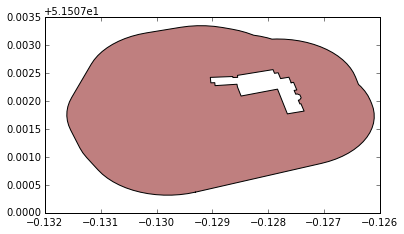

In [208]:
place_n = '(NHM) SOUTH KENSINGTON'
place_n = 'NATIONAL GALLERY'
place_polys_museum_convex_hull_gpdf_bfr[place_polys_museum_convex_hull_gpdf_bfr.place==place_n].plot()

In [142]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from leaflet_creation_v2 import create_map_visualization

In [215]:
# check whether there is obvious mistake of places,
# for example, use the national protrait gallery in DC for the NPG in England
html_title = 'england museums'
file_name = 'england museums'
lon, lat  = -0.17869653562200458, 51.49451759485569
zoom = 18
init_layers = ['streets', 'stsg_layer']
map_layers = ['light','streets']
binding_data=[['stsg','street segment']]
gpdf = gp.GeoDataFrame(place_polys_museum, columns=['place','cntr','radius','poly'])
gpdf['geometry'] = gpdf.cntr.apply(lambda x: shpgeo.Point(x))
gpdfs = [gpdf.drop(['cntr','radius','poly'],axis=1)]
place_polys_museum_convex_hull_gpdf_vis = place_polys_museum_convex_hull_gpdf_bfr.copy()
place_polys_museum_convex_hull_gpdf_vis['color'] = '#F00'
gpdfs = [place_polys_museum_convex_hull_gpdf_vis]
create_map_visualization(html_title, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

# getting polys to file

In [4]:
polys = []
national_parks = []
with open(osm2poly,'w') as f:
    for i, file_path in enumerate(glob.glob(data_file_dir+'/*')):
        _, name = file_path.rsplit('\\',1)
        print i, name
        name_pattern = name+'_%s_%s_%d.json'
        for entity in parse_file(file_path):
            print entity.id, is_closed_way(entity)
            ln = way2line(entity)
            poly = shpgeo.Polygon(ln)
            out_str = handle_poly(poly)
            polys.append(poly)
            national_parks.append(name_pattern)
            f.write(out_str)
        break

0 (NHM) SOUTH KENSINGTON.xml
24436446 True
1 (NHM) TRING.xml
412803079 True
2 (RA) FORT NELSON.xml
22927416 True
3 (RA) LEEDS.xml
78431237 True
4 (RA) WHITE TOWER.xml
369135772 True
5 (V&A) BLYTHE HOUSE.xml
24538730 True
6 (V&A) CHILDHOOD.xml
10790633 True
7 (V&A) SOUTH KENSINGTON.xml
4960173 True
8 BRITISH MUSEUM.xml
40405915 True
9 CHURCHILL WAR ROOMS (IWM).xml
139726525 True
10 GEFFRYE MUSEUM.xml
107807460 True
11 HMS BELFAST (IWM).xml
5006061 True
12 HORNIMAN MUSEUM.xml
210442848 True
13 IWM DUXFORD1.xml
26521006 True
14 IWM DUXFORD2.xml
22001428 True
15 IWM DUXFORD3.xml
22001427 True
16 IWM DUXFORD4.xml
22001429 True
17 IWM DUXFORD5.xml
22001420 True
18 IWM DUXFORD6.xml
22001424 True
19 IWM DUXFORD7.xml
115136080 True
20 IWM DUXFORD8.xml
22001422 True
21 IWM DUXFORD9.xml
22001423 True
22 IWM NORTH1.xml
187293587 True
23 IWM NORTH2.xml
187293585 True
24 NATIONAL COAL MINING MUSEUM.xml
249355161 True
25 NATIONAL GALLERY.xml
4372002 True
26 NATIONAL PORTRAIT GALLERY.xml
48041275 True

In [5]:

with open(osm2bbox,'w') as f:
    for i, file_path in enumerate(glob.glob(data_file_dir+'/*')):
        _, name = file_path.rsplit('\\',1)
        name = name[:-4]
        print i, name, national_parks[i]
        name_pattern = name+'_%s_%s_%d.json'
        poly = polys[i]
        bbox = poly.bounds
        bbox_str = ','.join([str(x)for x in bbox])
        center_str = '%.6f,%.6f' %(poly.centroid.coords[0][1], poly.centroid.coords[0][0])
        f.write('%s\t%s\t%s\n' %(name_pattern, center_str, bbox_str))
        

0 (NHM) SOUTH KENSINGTON (NHM) SOUTH KENSINGTON.xml_%s_%s_%d.json
1 (NHM) TRING (NHM) TRING.xml_%s_%s_%d.json
2 (RA) FORT NELSON (RA) FORT NELSON.xml_%s_%s_%d.json
3 (RA) LEEDS (RA) LEEDS.xml_%s_%s_%d.json
4 (RA) WHITE TOWER (RA) WHITE TOWER.xml_%s_%s_%d.json
5 (V&A) BLYTHE HOUSE (V&A) BLYTHE HOUSE.xml_%s_%s_%d.json
6 (V&A) CHILDHOOD (V&A) CHILDHOOD.xml_%s_%s_%d.json
7 (V&A) SOUTH KENSINGTON (V&A) SOUTH KENSINGTON.xml_%s_%s_%d.json
8 BRITISH MUSEUM BRITISH MUSEUM.xml_%s_%s_%d.json
9 CHURCHILL WAR ROOMS (IWM) CHURCHILL WAR ROOMS (IWM).xml_%s_%s_%d.json
10 GEFFRYE MUSEUM GEFFRYE MUSEUM.xml_%s_%s_%d.json
11 HMS BELFAST (IWM) HMS BELFAST (IWM).xml_%s_%s_%d.json
12 HORNIMAN MUSEUM HORNIMAN MUSEUM.xml_%s_%s_%d.json
13 IWM DUXFORD1 IWM DUXFORD1.xml_%s_%s_%d.json
14 IWM DUXFORD2 IWM DUXFORD2.xml_%s_%s_%d.json
15 IWM DUXFORD3 IWM DUXFORD3.xml_%s_%s_%d.json
16 IWM DUXFORD4 IWM DUXFORD4.xml_%s_%s_%d.json
17 IWM DUXFORD5 IWM DUXFORD5.xml_%s_%s_%d.json
18 IWM DUXFORD6 IWM DUXFORD6.xml_%s_%s_%d.json

In [14]:

with open(osm2bbox,'w') as f:
    for i, file_path in enumerate(glob.glob(data_file_dir+'/*')):
        _, name = file_path.rsplit('\\',1)
        name = name[:-4]
        print i, name
        name_pattern = name+'_%s_%s_%d.json'
        for entity in parse_file(file_path):
            print entity.id, is_closed_way(entity)
            ln = way2line(entity)
            poly = shpgeo.Polygon(ln)
            bbox = poly.bounds
            bbox_str = ','.join([str(x)for x in bbox])
            center_str = '%.6f,%.6f' %(poly.centroid.coords[0][1], poly.centroid.coords[0][0])
            f.write('%s\t%s\t%s\n' %(name_pattern, center_str, bbox_str))

0 (NHM) SOUTH KENSINGTON
24436446 True
1 (NHM) TRING
412803079 True
2 (RA) FORT NELSON
22927416 True
3 (RA) LEEDS
78431237 True
4 (RA) WHITE TOWER
369135772 True
5 (V&A) BLYTHE HOUSE
24538730 True
6 (V&A) CHILDHOOD
10790633 True
7 (V&A) SOUTH KENSINGTON
4960173 True
8 BRITISH MUSEUM
40405915 True
9 CHURCHILL WAR ROOMS (IWM)
139726525 True
10 GEFFRYE MUSEUM
107807460 True
11 HMS BELFAST (IWM)
5006061 True
12 HORNIMAN MUSEUM
210442848 True
13 IWM DUXFORD1
26521006 True
14 IWM DUXFORD2
22001428 True
15 IWM DUXFORD3
22001427 True
16 IWM DUXFORD4
22001429 True
17 IWM DUXFORD5
22001420 True
18 IWM DUXFORD6
22001424 True
19 IWM DUXFORD7
115136080 True
20 IWM DUXFORD8
22001422 True
21 IWM DUXFORD9
22001423 True
22 IWM NORTH1
187293587 True
23 IWM NORTH2
187293585 True
24 NATIONAL COAL MINING MUSEUM
249355161 True
25 NATIONAL GALLERY
4372002 True
26 NATIONAL PORTRAIT GALLERY
48041275 True
27 ROYAL MUSEUMS GREENWICH
183090507 True
28 SCIENCE AND INDUSTRY MANCHESTER
205197227 True
29 SCIENCE LOCO

OverpassTooManyRequests: Too many requests